# Downloading and Analyzing Stock Data with fintorch

<a target="_blank" href="https://colab.research.google.com/github/AI4FinTech/FinTorch/blob/main/docs/tutorials/stocktick/stocktick.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In this tutorial, we'll explore how to use the `fintorch` Python package to download historical stock data and prepare it for machine learning tasks. Specifically, we'll focus on Apple (AAPL), Microsoft (MSFT), and Google (GOOG) stocks from January 1, 2015, to June 30, 2023. We'll also discuss how `fintorch` integrates with the `neuralforecast` library by providing a `TimeSeriesDataset` that's compatible with its data structures, making it easier to organize data for training, validation, and testing.


## Overview


The `fintorch` library is designed for financial data analysis and machine learning applications. It simplifies the process of downloading, storing, and preparing financial datasets. Under the hood, it uses `yfinance` to retrieve data from Yahoo Finance, ensuring a reliable and comprehensive data source.

One of the key features of `fintorch` is that it provides data in a `TimeSeriesDataset` format compatible with the `neuralforecast` library. This compatibility streamlines the process of organizing time series data for machine learning models, including handling train/validation/test splits.


## Step-by-Step Explanation

Let's break down the code to understand how each part contributes to downloading and analyzing the stock data.

In [1]:
import logging
from datetime import date
from pathlib import Path

from fintorch.datasets import stockticker

- **Importing Modules**:
  - `logging`: For logging information during execution.
  - `date` from `datetime`: To specify the start and end dates for the data.
  - `Path` from `pathlib`: To handle file system paths.
  - `stockticker` from `fintorch.datasets`: Contains the `StockTicker` class for handling stock data.

In [2]:
# Set logging level to INFO
logging.basicConfig(level=logging.INFO)

- **Setting Logging Level**: Configures the logging system to display messages of level `INFO` and higher.


In [3]:
# Parameters
tickers = ["AAPL", "MSFT", "GOOG"]
data_path = Path("~/.fintorch_data/stocktickers/").expanduser()
start_date = date(2015, 1, 1)
end_date = date(2023, 6, 30)

- **Defining Parameters**:
  - `tickers`: A list of stock ticker symbols we're interested in.
  - `data_path`: The directory path where the stock data will be stored locally.
  - `start_date` and `end_date`: Define the time range for the historical data.

In [4]:
# Create a dictionary mapping from tickers to index
ticker_index = {ticker: index for index, ticker in enumerate(tickers)}

- **Mapping Tickers to Indices**:
  - Creates a dictionary that maps each ticker symbol to a unique index. This can be useful for referencing and organizing data.


In [5]:
# Load the stock dataset
stockdata = stockticker.StockTicker(
    data_path,
    tickers=tickers,
    start_date=start_date,
    end_date=end_date,
    mapping=ticker_index,
    force_reload=True,
)

INFO:root:StockTicker dataset initialization
INFO:root:force reloading stock data from yahoo finance
[*********************100%%**********************]  3 of 3 completed
INFO:root:All datsets loaded sucessfully
INFO:root:loaded dataset:TimeSeriesDataset(n_data=8,655, n_groups=3)


- **Loading the Stock Data**:
  - Instantiates the `StockTicker` class with the specified parameters.
  - **Parameters Explained**:
    - `data_path`: Where the data will be stored.
    - `tickers`: The list of stock symbols.
    - `start_date` and `end_date`: The date range for the data.
    - `mapping`: The ticker-to-index mapping.
    - `force_reload=True`: Forces the data to be re-downloaded even if it already exists locally.
  - **Under the Hood**:
    - The `StockTicker` class uses `yfinance` to fetch the stock data from Yahoo Finance.
    - It organizes the data into a `TimeSeriesDataset` compatible with the `neuralforecast` library.

In [6]:
print(stockdata.df_timeseries_dataset.to_pandas().describe())

                               ds            y    unique_id
count                        8655  8655.000000  8655.000000
mean   2020-02-26 03:56:05.407000   118.096947     1.000000
min           2015-01-02 00:00:00    20.697262     0.000000
25%           2017-11-10 00:00:00    49.313992     0.000000
50%           2020-09-24 00:00:00   103.036682     1.000000
75%           2022-07-15 00:00:00   155.169968     2.000000
max           2023-06-29 00:00:00   344.776672     2.000000
std                           NaN    80.441103     0.816544


## Integration with `neuralforecast`

### TimeSeriesDataset Compatibility

The `stockdata.df_timeseries_dataset` provided by `fintorch` is designed to be compatible with the `TimeSeriesDataset` format used by the `neuralforecast` library. This compatibility is significant because it:

- **Simplifies Data Preparation**: The data is already organized in a way that's suitable for machine learning models, reducing the need for additional data wrangling.
- **Eases Train/Validation/Test Splits**: `neuralforecast` has built-in methods for splitting datasets, and having data in the compatible format allows you to leverage these methods directly.
- **Facilitates Model Training and Evaluation**: Consistent data formatting ensures smoother integration with `neuralforecast` models and evaluation metrics.


### Example of Using TimeSeriesDataset with `neuralforecast`

Here's how you might proceed to use the dataset with `neuralforecast`:

In [7]:
print(stockdata.df_timeseries_dataset.to_pandas())

             ds           y  unique_id
0    2022-01-03  179.076599          0
1    2022-01-04  176.803833          0
2    2022-01-05  172.100861          0
3    2022-01-06  169.227921          0
4    2022-01-07  169.395172          0
...         ...         ...        ...
8650 2023-06-23  122.718620          2
8651 2023-06-26  118.798248          2
8652 2023-06-27  118.718452          2
8653 2023-06-28  120.783379          2
8654 2023-06-29  119.716003          2

[8655 rows x 3 columns]


In [8]:
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATS

# Initialize the model
model = NBEATS(input_size=30, h=7)

# Create a NeuralForecast object
nf = NeuralForecast(models=[model], freq='D')

# Define validation and test sizes
val_size = 100  # Number of days for validation
test_size = 100  # Number of days for testing

# Perform cross-validation
Y_hat_df = nf.cross_validation(
    df=stockdata.df_timeseries_dataset.to_pandas(),
    val_size=val_size,
    test_size=test_size,
    n_windows=None  # Uses expanding window if None
)


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.4 M  | train
-------------------------------------------------------
2.4 M     Trainable params
555       Non-trainable params
2.4 M     Total params
9.786     Total esti

Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 48.77it/s, v_num=12, train_loss_step=2.200, train_loss_epoch=2.200, valid_loss=2.410] 

`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 45.46it/s, v_num=12, train_loss_step=2.200, train_loss_epoch=2.200, valid_loss=2.410]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 269.38it/s]


/home/marcel/Documents/research/FinTorch/.conda/lib/python3.11/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


Here we plot the mean prediction of the cross validation function for the 4-folds

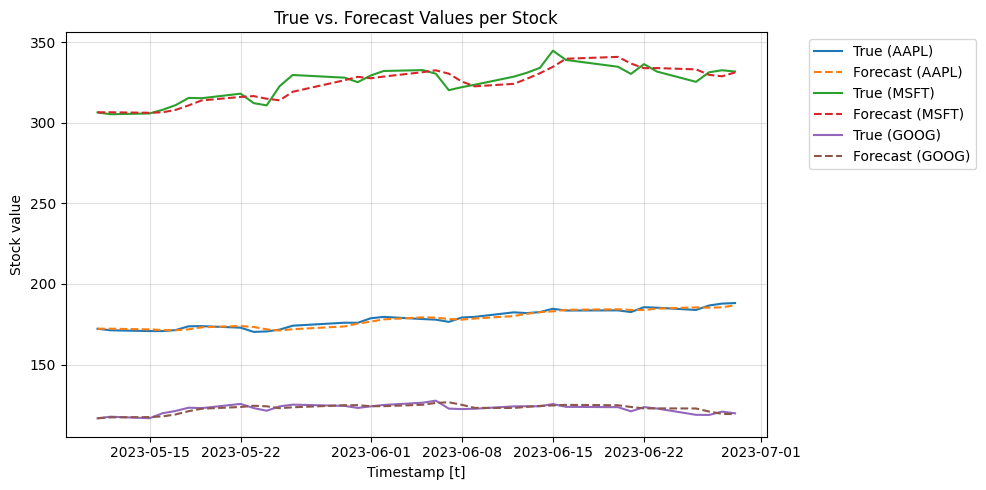

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

# Iterate through each unique stock using the index
for unique_id in Y_hat_df.index.unique():
    stock_data = Y_hat_df.loc[unique_id] # Index-based selection
    stock_data = stock_data.reset_index().groupby('ds').mean().reset_index()

    # Plot true values and forecast for the current stock
    plt.plot(stock_data['ds'], stock_data['y'], label=f'True ({tickers[unique_id]})')
    plt.plot(stock_data['ds'], stock_data['NBEATS'], label=f'Forecast ({tickers[unique_id]})', linestyle='--')  # Dashed line for forecast



# General plot formatting
plt.xlabel('Timestamp [t]')
plt.ylabel('Stock value')
plt.title('True vs. Forecast Values per Stock')
plt.grid(alpha=0.4)  

# Adjust legend to fit better
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') 

plt.tight_layout() 
plt.show()

## Understanding `yfinance`

`yfinance` is a Python library that provides a convenient way to download historical market data from Yahoo Finance. It supports a wide range of data, including:

- Historical prices
- Dividends
- Splits
- Financial statements

In this tutorial, `fintorch` leverages `yfinance` to handle the data retrieval of stocktick data, making it seamless to obtain and work with financial datasets.

## Conclusion

By following this tutorial, you've learned how to:

- Set up logging for better debugging and information tracking.
- Specify parameters for data retrieval, including tickers and date ranges.
- Use `fintorch` and `yfinance` to download historical stock data.
- Obtain a `TimeSeriesDataset` compatible with `neuralforecast`, simplifying the process of preparing data for machine learning models.

This foundational knowledge can be expanded upon for more complex analyses, such as building financial models or integrating advanced machine learning algorithms.

## Next Steps

- **Explore the Data**: Use visualization libraries like Matplotlib or Seaborn to plot the stock prices and observe trends.
- **Feature Engineering**: Create additional features such as moving averages, volatility indicators, or technical analysis signals.
- **Model Training**: Use the prepared `TimeSeriesDataset` to train machine learning models using `neuralforecast` or other libraries like TensorFlow or PyTorch.
- **Model Evaluation**: Implement evaluation metrics to assess the performance of your models on validation and test sets.

